In [36]:
!pip install pandas scikit-learn imbalanced-learn matplotlib joblib

  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0


In [37]:
import pandas as pd

# Carregando os dados a partir do CSV
df = pd.read_csv("dados_sensores.csv")

# Convertendo o timestamp para tipo datetime
df["data_hora_leitura"] = pd.to_datetime(df["data_hora_leitura"])

# Transformando os dados por sensor em colunas
df_pivot = df.pivot_table(
    index="data_hora_leitura",
    columns="id_sensor",
    values="valor_sensor"
)

# Renomeando colunas para nomes amigáveis
df_pivot.columns = ["fosforo", "potassio", "ph", "umidade", "irrigacao"]

# Removendo linhas com dados faltantes (NaN)
df_pivot = df_pivot.dropna()

# Visualização inicial
df_pivot.head()

,fosforo,potassio,ph,umidade,irrigacao
data_hora_leitura,,,,,
2025-04-02 08:00:00,1.0,0.0,6.5,35.2,0.0
2025-04-02 08:30:00,0.8,1.0,6.7,33.7,1.0
2025-04-02 09:00:00,0.9,0.0,6.9,31.5,0.0
2025-04-02 09:30:00,1.1,1.0,7.1,29.8,0.0
2025-04-02 10:00:00,1.2,0.0,7.3,28.3,1.0


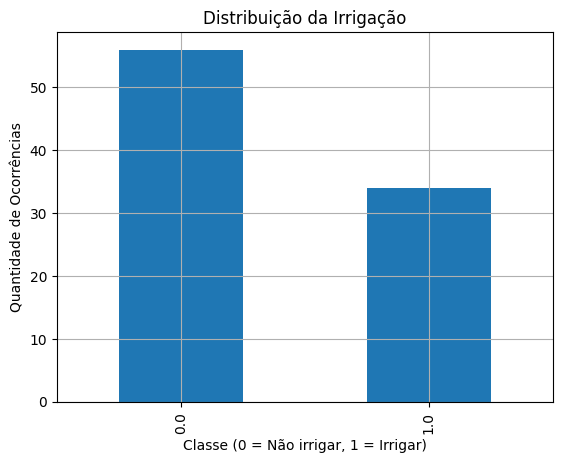

In [38]:
import matplotlib.pyplot as plt

# Visualização da distribuição de classes
df_pivot["irrigacao"].value_counts().plot(kind="bar", title="Distribuição da Irrigação")
plt.xlabel("Classe (0 = Não irrigar, 1 = Irrigar)")
plt.ylabel("Quantidade de Ocorrências")
plt.grid(True)
plt.show()

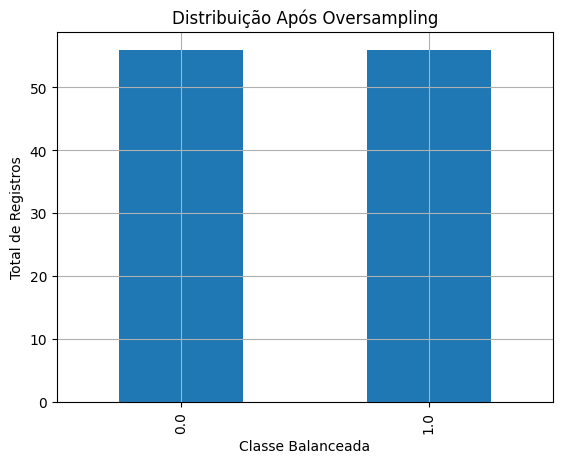

In [39]:
# Implementação alternativa ao RandomOverSampler
import numpy as np

# Separação entre entradas e saída
X = df_pivot[["fosforo", "potassio", "ph", "umidade"]]
y = df_pivot["irrigacao"]

# Implementação manual de oversampling
# Identificar os índices de cada classe
class_0_indices = y[y == 0].index
class_1_indices = y[y == 1].index

# Determinar qual é a classe minoritária e majoritária
if len(class_0_indices) < len(class_1_indices):
    minority_class = 0
    minority_indices = class_0_indices
    majority_indices = class_1_indices
else:
    minority_class = 1
    minority_indices = class_1_indices
    majority_indices = class_0_indices

# Quantidade da classe majoritária
n_majority = len(majority_indices)

# Sobreamostragem da classe minoritária (com substituição)
minority_upsampled_indices = np.random.choice(
    minority_indices,
    size=n_majority,
    replace=True
)

# Combinando os índices
balanced_indices = np.concatenate([majority_indices, minority_upsampled_indices])

# Criando o conjunto de dados balanceado
X_res = X.loc[balanced_indices]
y_res = y.loc[balanced_indices]

# Visualização da nova distribuição
pd.Series(y_res).value_counts().plot(kind="bar", title="Distribuição Após Oversampling")
plt.xlabel("Classe Balanceada")
plt.ylabel("Total de Registros")
plt.grid(True)
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Treinamento do modelo
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Avaliação com métricas de classificação
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81        15
         1.0       0.64      0.88      0.74         8

    accuracy                           0.78        23
   macro avg       0.78      0.80      0.78        23
weighted avg       0.82      0.78      0.79        23



In [42]:
import joblib

# Exportando o modelo treinado para um arquivo .pkl
joblib.dump(modelo, "../dashboard/modelo_irrigacao.pkl")

# Exportando o dataset balanceado
df_balanceado = X_res.copy()
df_balanceado["irrigacao"] = y_res
df_balanceado.to_csv("../dashboard/dataset_balanceado.csv", index=False)

print("Modelo e base balanceada salvos com sucesso!")

Modelo e base balanceada salvos com sucesso!
